# 第6回課題
前処理と特徴量選択により，SVM の最初のスコアよりも1割程度良いテストスコアを出してください．
ちょこっといじった程度では，線形回帰はスコアが変わらなかったので，参考程度に使ってください

### 必須事項
- 前処理：正規化，標準化，外れ値の排除など
- 特徴量選択: 検証は必須．増やす・減らす・変えないの結果は自由
- テストスコアの向上: mse で 0.41 くらいは出ると思います

### 自由事項
- 指標の変更
- パラメータの変更（モデルの変更は想定してません）

### 余談
特徴量選択で正解を用意するのは，やはり難しいなと解答を作る時に感じました．解答の方は最低限の考察と検証をしていますが，4時間かかりました( ;∀;)

## 注意事項
特徴量の分析時に分割したデータを使ってない時点でせこいというか，おかしいです．ここでは無視していますが，本来はできません．

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

For more information, read [Cortez et al., 2009].
Input variables (based on physicochemical tests):

- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol

Output variable (based on sensory data):
- quality (score between 0 and 10)

In [2]:
wine_quality_df = pd.read_csv("winequality-red.csv",delimiter=";")
print(wine_quality_df.shape)
wine_quality_df.head()

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
wine_quality_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [4]:
feature_names = list(np.copy(wine_quality_df.columns))
feature_names.remove("quality")

In [5]:
X_train, X_test, y_train, y_test = \
    train_test_split(wine_quality_df[feature_names], wine_quality_df["quality"], 
                     test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((1119, 11), (480, 11))

## 注意
ここで，test score まで同時に出してしまっているんですが，1つの関数で実行してしまう方が楽だったという理由だけで，これらは分けた方が良いです．
パラメータや特徴量について考えるときには，CV だけで調整すべきです

In [6]:
kfold = KFold(n_splits=5, random_state=0)
def cross_validation(model, test=True):
    global X_train, X_test, y_train, y_test, feature_names
    scores = cross_val_score(model, X_train[feature_names], y_train, cv=kfold, 
                             scoring=make_scorer(mean_squared_error))
    # 各分割におけるスコア
    print('Cross-Validation scores: {}'.format(scores))
    # スコアの平均値
    print('Average score: {}'.format(np.mean(scores)))
    if test:
        model.fit(X_train[feature_names], y_train)
        pred = model.predict(X_test[feature_names])
        print('Test score: {}'.format(mean_squared_error(y_test, pred)))

# モデルによる予測

In [7]:
linear_reg = Ridge(random_state=0)
cross_validation(linear_reg)

Cross-Validation scores: [0.48812538 0.48841541 0.42327305 0.42566563 0.36728215]
Average score: 0.4385523259892648
Test score: 0.4010466305154148


In [8]:
svm_clf = SVC(kernel="rbf", random_state=0)
cross_validation(svm_clf)

Cross-Validation scores: [0.67857143 0.82142857 0.71428571 0.75446429 0.62780269]
Average score: 0.719310538116592
Test score: 0.68125


In [9]:
svm_reg = SVR(kernel="rbf")
cross_validation(svm_reg)

Cross-Validation scores: [0.5715145  0.68175944 0.57909369 0.61098986 0.50245379]
Average score: 0.5891622546486783
Test score: 0.5085468469038228


# 以降にコードを追加

In [10]:
wine_quality_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [11]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [12]:
wine_df_mine = wine_quality_df.copy()

In [13]:
#scaler = MinMaxScaler()
scaler = StandardScaler()

In [14]:
#wine_df_mine[feature_names] = scaler.fit_transform(wine_df_mine[feature_names])

In [15]:
#wine_df_mine.describe()

# 特徴量検証

各特徴量  
fixed acidity - 酒石酸濃度  
volatile acidity - 酢酸濃度  
citric acid - クエン酸濃度  
residual sugar - 残糖濃度  
chlorides -  塩化ナトリウム濃度  
free sulfur dioxide - 遊離SO2（二酸化硫黄）濃度  
total sulfur dioxide - 総SO2（二酸化硫黄）濃度  
density - 密度  
pH - 水素イオン濃度  
sulphates - 硫化カリウム濃度  
alcohol - アルコール度数  

https://koki12070930.hatenablog.com/entry/wine-quality  より

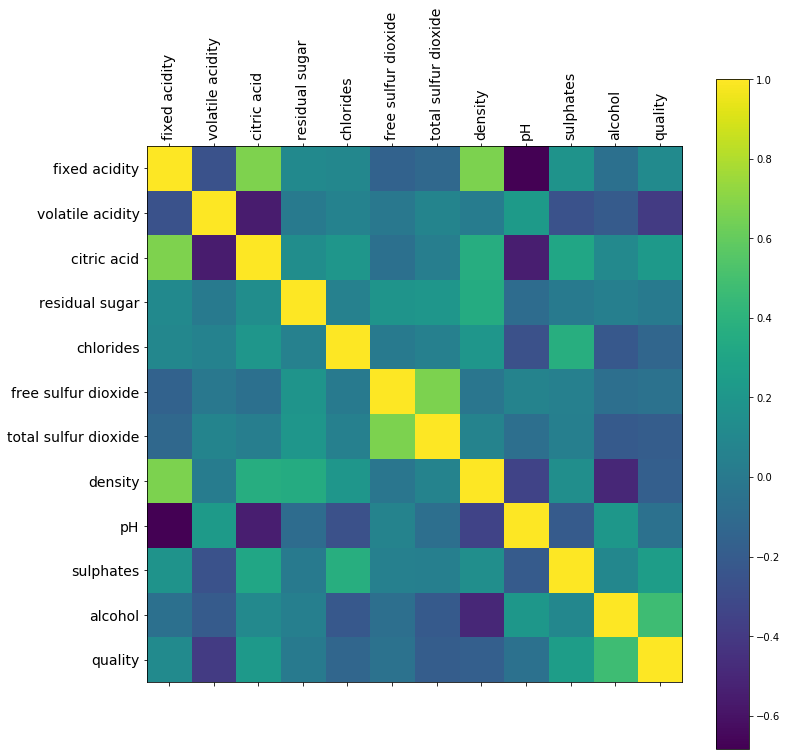

In [16]:
fig = plt.figure(figsize=(12, 12))
plt.matshow(wine_df_mine.corr("pearson"), fignum=fig.number)
plt.xticks(range(wine_df_mine.shape[1]), wine_df_mine.columns, fontsize=14, rotation=90)
plt.yticks(range(wine_df_mine.shape[1]), wine_df_mine.columns, fontsize=14)
plt.colorbar()

In [17]:
corr = wine_df_mine.corr().values
[[wine_df_mine.columns[i], wine_df_mine.columns[j], corr[i][j]] for i in range(wine_df_mine.shape[1]-1) for j in range(wine_df_mine.shape[1]-1) if abs(corr[i][j]) >= 0.4 and corr[i][j] != 1]

[['fixed acidity', 'citric acid', 0.6717034347641041],
 ['fixed acidity', 'density', 0.6680472921189711],
 ['fixed acidity', 'pH', -0.6829781945685299],
 ['volatile acidity', 'citric acid', -0.5524956845595839],
 ['citric acid', 'fixed acidity', 0.6717034347641041],
 ['citric acid', 'volatile acidity', -0.5524956845595839],
 ['citric acid', 'pH', -0.5419041447395132],
 ['free sulfur dioxide', 'total sulfur dioxide', 0.6676664504810212],
 ['total sulfur dioxide', 'free sulfur dioxide', 0.6676664504810212],
 ['density', 'fixed acidity', 0.6680472921189711],
 ['density', 'alcohol', -0.49617977024170085],
 ['pH', 'fixed acidity', -0.6829781945685299],
 ['pH', 'citric acid', -0.5419041447395132],
 ['alcohol', 'density', -0.49617977024170085]]

・ワインの成分という性質上，qualityとの相関が低くても品質に寄与しないとは限らない  
・相関が高い特徴量同士の組み合わせも存在するが，それぞれの特徴量について調べたところそれらにあまり関連性はなさそう（sulfur2種ぐらいか）  
よって今回は特徴量の削減は行わないものとする

(array([ 10.,   0.,  53.,   0., 681.,   0., 638.,   0., 199.,  18.]),
 array([3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ]),
 <a list of 10 Patch objects>)

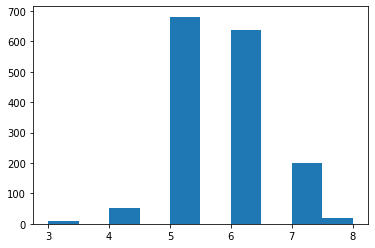

In [19]:
plt.hist(wine_df_mine['quality'])

qualityは離散値だがワインの10段階評価なので回帰の方が適切?

In [20]:
feature_names = list(np.copy(wine_quality_df.columns))
feature_names.remove("quality")

In [21]:
feature_names

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [59]:
X_train, X_test, y_train, y_test = \
    train_test_split(wine_df_mine[feature_names], wine_df_mine["quality"], 
                     test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((1119, 11), (480, 11))

In [24]:
X_train[feature_names]= scaler.fit_transform(X_train[feature_names])
X_test[feature_names] = scaler.transform(X_test[feature_names])

標準化のみ行った場合

In [25]:
svm_clf = SVC(kernel="rbf", random_state=0)
cross_validation(svm_clf)

Cross-Validation scores: [0.56696429 0.52678571 0.5        0.52678571 0.4529148 ]
Average score: 0.5146901024983984
Test score: 0.4583333333333333


In [26]:
svm_reg = SVR(kernel="rbf")
cross_validation(svm_reg)

Cross-Validation scores: [0.45148575 0.42211498 0.38000374 0.4269028  0.3493321 ]
Average score: 0.40596787342893403
Test score: 0.3873727306496461


In [27]:
X_train, X_test, y_train, y_test = \
    train_test_split(wine_df_mine[feature_names], wine_df_mine["quality"], 
                     test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((1119, 11), (480, 11))

In [28]:
#trainから外れ値除去
df_train = pd.concat([X_train, y_train], axis=1)
for i in range(len(feature_names)):

    # 列を抽出する
    col = df_train.iloc[:,i]

    # 四分位数
    q1 = col.describe()['25%']
    q3 = col.describe()['75%']
    iqr = q3 - q1 #四分位範囲

    # 外れ値の基準点
    outlier_min = q1 - (iqr) * 1.5
    outlier_max = q3 + (iqr) * 1.5

    # 範囲から外れている値を除く
    col[col < outlier_min] = None
    col[col > outlier_max] = None
df_train = df_train.dropna(how='any', axis=0)
X_train = df_train[feature_names]
y_train = df_train['quality']

C:\Users\takay\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\takay\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [29]:
X_train[feature_names]= scaler.fit_transform(X_train[feature_names])
X_test[feature_names] = scaler.transform(X_test[feature_names])

C:\Users\takay\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\takay\anaconda3\lib\site-packages\pandas\core\frame.py:2969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
C:\Users\takay\anaconda3\lib\site-packages\pandas\core\frame.py:2935: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

四分位範囲の1.5倍を外れ値基準として外れ値の除去を行った場合

In [30]:
svm_clf = SVC(kernel="rbf", random_state=0)
cross_validation(svm_clf)

Cross-Validation scores: [0.56626506 0.52409639 0.46666667 0.47272727 0.50909091]
Average score: 0.5077692588535963
Test score: 0.53125


In [31]:
svm_reg = SVR(kernel="rbf")
cross_validation(svm_reg)

Cross-Validation scores: [0.45995409 0.38965691 0.3603828  0.32093778 0.36889722]
Average score: 0.3799657614701938
Test score: 0.4279763300726371


In [33]:
X_train.shape

(827, 11)

trainの外れ値を除去したところ精度は悪化  
外れ値の基準に問題あり?